### Conv size calculator

https://madebyollin.github.io/convnet-calculator

https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d


### Imports

In [49]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix#,plot_confusion_matrix
from sklearn import metrics
import itertools

%matplotlib inline

### Load data

In [6]:
train_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    transform = transforms.ToTensor(),
    download=True
)



0it [00:00, ?it/s]

  0%|                                                                                                                     | 0/26421880 [00:00<?, ?it/s]

  0%|                                                                                                      | 16384/26421880 [00:01<06:21, 69131.43it/s]

  0%|▏                                                                                                     | 40960/26421880 [00:01<04:49, 91275.87it/s]

  0%|▏                                                                                                    | 57344/26421880 [00:01<04:01, 109101.57it/s]

  0%|▎                                                                                                    | 81920/26421880 [00:01<03:26, 127568.15it/s]

  0%|▍                                                                                                   | 122880/26421880 [00:01<02:13, 196534.45it/s]

  1%|▌                                                      

 39%|█████████████████████████████████████▊                                                           | 10313728/26421880 [00:08<00:15, 1061646.67it/s]

 40%|██████████████████████████████████████▋                                                          | 10534912/26421880 [00:08<00:12, 1297279.45it/s]

 40%|███████████████████████████████████████▏                                                         | 10682368/26421880 [00:08<00:11, 1340836.98it/s]

 41%|███████████████████████████████████████▉                                                         | 10870784/26421880 [00:08<00:10, 1466699.49it/s]

 42%|████████████████████████████████████████▌                                                        | 11034624/26421880 [00:08<00:11, 1379474.60it/s]

 43%|█████████████████████████████████████████▍                                                       | 11272192/26421880 [00:08<00:09, 1632989.85it/s]

 44%|██████████████████████████████████████████▎                                  

 80%|██████████████████████████████████████████████████████████████████████████████▏                   | 21094400/26421880 [00:16<00:10, 500398.59it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 21151744/26421880 [00:16<00:10, 486341.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 21209088/26421880 [00:16<00:10, 481731.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                   | 21258240/26421880 [00:16<00:10, 472395.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████                   | 21323776/26421880 [00:16<00:11, 454035.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 21413888/26421880 [00:16<00:09, 533337.80it/s]

 81%|█████████████████████████████████████████████████████████████████████████████

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 23994368/26421880 [00:22<00:07, 311154.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 24035328/26421880 [00:22<00:07, 315498.37it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 24076288/26421880 [00:23<00:07, 325611.36it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 24117248/26421880 [00:23<00:07, 321486.32it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 24158208/26421880 [00:23<00:06, 337275.18it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 24199168/26421880 [00:23<00:06, 337649.37it/s]

 92%|█████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 26378240/26421880 [00:29<00:00, 361357.68it/s]

26427392it [00:29, 386626.27it/s]                                                                                                                      

Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz





0it [00:00, ?it/s]


  0%|                                                                                                                        | 0/29515 [00:00<?, ?it/s]


 56%|██████████████████████████████████████████████████████████▎                                              | 16384/29515 [00:01<00:00, 70924.01it/s]

Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz






0it [00:00, ?it/s]



  0%|                                                                                                                      | 0/4422102 [00:00<?, ?it/s]



  0%|▍                                                                                                      | 16384/4422102 [00:00<01:02, 70924.96it/s]



  1%|▉                                                                                                      | 40960/4422102 [00:01<00:46, 94435.29it/s]



  1%|█▌                                                                                                    | 65536/4422102 [00:01<00:33, 128303.70it/s]



  2%|██                                                                                                    | 90112/4422102 [00:01<00:28, 153301.80it/s]



  3%|██▊                                                                                                  | 122880/4422102 [00:01<00:21, 196557.74it/s]



  4%|███▋                                   

Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz







0it [00:00, ?it/s]




  0%|                                                                                                                         | 0/5148 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!




26427392it [00:49, 386626.27it/s]


32768it [00:18, 70924.01it/s]                                                                                                                          



4423680it [00:17, 1938335.04it/s]                                                                                                                      

In [7]:
train_dataset.data.max()

0it [11:50, ?it/s]
26427392it [11:33, 38090.97it/s] 
32768it [11:03, 49.41it/s]   
4423680it [11:01, 6682.91it/s]   
8192it [10:56, 12.48it/s]                                                                                                                              


tensor(255, dtype=torch.uint8)

In [8]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [9]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [10]:
test_dataset = torchvision.datasets.FashionMNIST(
    root=".",
    train=False ,
    transform = transforms.ToTensor(),
    download=True
)

In [11]:
def classes_counter(dataset):
    K = len(set(dataset.targets.numpy()))
    return K

In [17]:
K = classes_counter(train_dataset)
print(K)

10


### Create model

In [29]:
class CNN(nn.Module):
    def __init__(self,K):
        super(CNN,self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU(),            
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,K)
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0),-1)
        out = self.dense_layers(out)
        return out

    
    
# not available at this version -- on my system
# class CNN_flatten(nn.Module):
#     def __init__(self,K):
#         super(CNN_flatten,self).__init__()
        
#         nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#             nn.ReLU(), 
            
#             nn.Flatten(),
            
#             nn.Dropout(0.2),
#             nn.Linear(128*2*2, 512),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(512,K)
#         )

In [56]:
def dataloader_batch(train_dataset,test_dataset,batch_size=128):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    # to prevent unwanted correlation in train_data we shuffle train data
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,test_loader


def create_model_and_train(K,train_dataset,test_dataset,batch_size=128,n_epochs=100):
    model = CNN(K)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_loader,test_loader = dataloader_batch(train_dataset,test_dataset,batch_size=batch_size)
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in test_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
                        
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it]  = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
        
    return train_losses, test_losses, device, train_loader, test_loader

In [57]:
train_losses, test_losses, device ,train_loader, test_loader = create_model_and_train(K,train_dataset,test_dataset,batch_size=128,n_epochs=1)

cpu
Epoch 1/1, Train Loss: 0.6741, Test Loss: 0.5185, Duration: 0:01:42.162557


In [58]:
def plot_test_and_train_metric(train, test, metric):
    plt.plot(train, label=f"train {metric}")
    plt.plot(test, label =f"test {metric}")
    plt.legend()
    plt.show

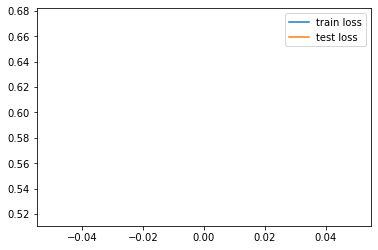

In [59]:
plot_test_and_train_metric(train_losses, test_losses,"loss")

In [64]:
def acc_compouter(model,device,data_loader):
    n_correct=0.
    n_total=0.
    
    for inputs,targets in data_loader:
        inputs,targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        _,predictions = torch.max(outputs,1)
        # 1 is the axis and  _ is the max value that is not needed here
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    train_acc = n_correct/n_total

    return train_acc

In [65]:
train_acc = acc_compouter(model,device,train_loader)
print(f"train acc: {train_acc}")

test_acc = acc_compouter(model,device,test_loader)
print(f"test acc: {test_acc}")

train acc: 0.0983
test acc: 0.0974


In [68]:
def predict_model(model,data_loader,dataset,device):
    x = dataset.data.numpy()
    y = dataset.targets.numpy()
    p = np.array([])
    for inputs,targets in data_loader:
        inputs = inputs.to(device)
        
        outputs = model(inputs)
        _,predictions = torch.max(outputs,1)
        p = np.concatenate((p,predictions.cpu().numpy()))
        
    return p,y,x

In [69]:
p_test,y_test,x_test = predict_model(model,test_loader,test_dataset,device)

In [70]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

Confusion matrix, without normalization
[[  0   0   0 939   0  59   2   0   0   0]
 [  0   0   0 816   0 181   3   0   0   0]
 [  0   0   0 894   0 104   2   0   0   0]
 [  0   0   0 867   0 127   6   0   0   0]
 [  0   0   0 901   0  98   1   0   0   0]
 [  0   0   0 890   0 108   2   0   0   0]
 [  0   0   0 897   0 102   1   0   0   0]
 [  2   0   0 899   0  97   2   0   0   0]
 [  0   0   0 863   0 134   3   0   0   0]
 [  0   0   0 939   0  55   6   0   0   0]]


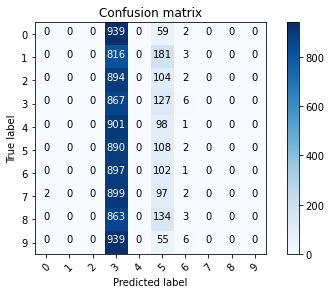

In [71]:
cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm, list(range(10)))

In [72]:
labels = '''
Tshirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot
'''.split("\n")

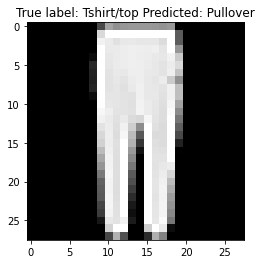

In [77]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test!=y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[int(p_test[i])]));